In [1]:
import time

import glob
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torchvision.models import resnet50, ResNet50_Weights

device = "cuda"

In [2]:
class TheDataset(Dataset):

    def __init__(self, paths, device="cpu"):
        self._transform = transforms.Compose([
            transforms.ToTensor(),  #
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
        ])
        self._height = 480
        self.inputs = [self._load_image(img_path) for img_path in paths]
        self.targets = [self._load_target(img_path) for img_path in paths]

    def _load_image(self, path):
        img = cv.imread(path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return self._transform(img)

    def _load_target(self, path):
        cells = path.split("-")[-2].split("_")
        return torch.tensor([float(cells[0]) / self._height, float(cells[1]) / self._height]).float()
    
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample at the given index
        return self.inputs[idx].to(device), self.targets[idx].to(device)

paths = [filepath for filepath in glob.glob("../data/new_data/*.jpg")]
dataset = TheDataset(paths[:100])


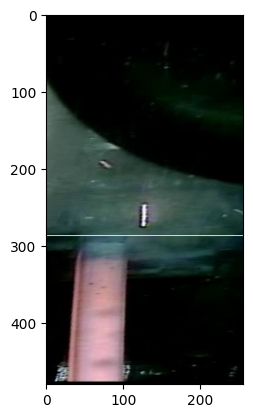

In [3]:
img, target = dataset[1]

image = img.permute(1, 2, 0).cpu().numpy()

t1, t2 = (target.cpu().numpy() * 480)

image[int(t1)] = 1
image[int(t2)] = 1

plt.imshow(image)
plt.show()

In [4]:
class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.fc_in_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        num_features = 256
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, num_features * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(num_features * 2, num_features),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(num_features, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return self.fc(output).squeeze(-1)



In [8]:
batch_size = 32

paths = [filepath for filepath in glob.glob("../data/new_data/*.jpg")]

train_dataset = TheDataset(paths[:1000], device=device)
val_dataset = TheDataset(paths[1000:1100], device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
epochs = 40

np.random.seed(101)

model = ModelV1().to(device)

criterion = nn.MSELoss()  # For regression tasks
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    for train_inputs, train_targets in train_dataloader:
        train_outputs = model(train_inputs)
        train_loss = criterion(train_outputs, train_targets)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses[epoch] += train_loss
        
    model.eval()
    errors = []
    for val_inputs, val_targets in val_dataloader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        val_losses[epoch] += val_loss
        errors.append(np.abs(val_targets.to("cpu").numpy() - val_outputs.detach().to("cpu").numpy()))
    mae = np.concatenate(errors).mean()

    if epoch % 1 == 0:
        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_losses[epoch]:.5f},  Validation Loss: {val_losses[epoch]:.5f}, "MAE: {mae:.3f}')


plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title(f"Best validation loss occur in epoch {val_losses.argmin()}")
plt.xlabel("Epoch index")
plt.ylabel("Loss [-]")
plt.yscale('log')
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 6.00 GiB total capacity; 12.56 GiB already allocated; 0 bytes free; 12.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

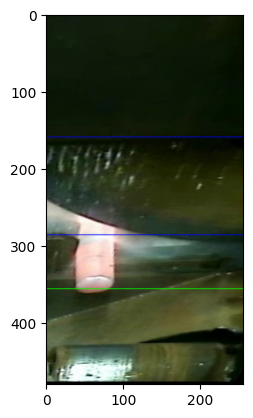

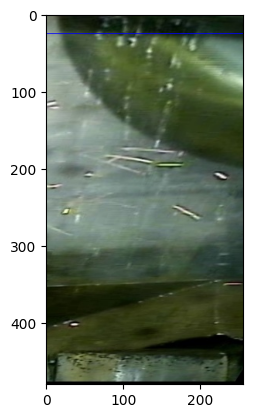

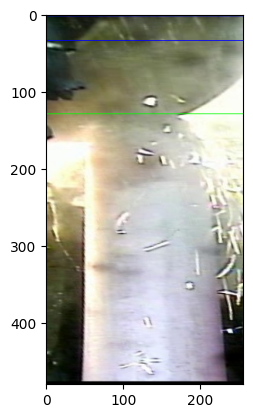

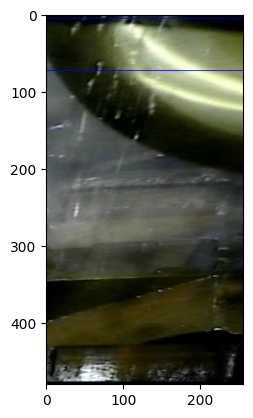

In [63]:

for val_inputs, val_targets in val_dataloader:
    val_outputs = model(val_inputs)

    for image, target, output in zip(val_inputs, val_targets, val_outputs):

        image = image.permute(1, 2, 0).cpu().numpy()
        t1, t2 = (target.cpu().numpy() * 480)
        o1, o2 = (output.detach().cpu().numpy() * 480)
    
        image[int(t1)] = (0, 1, 0)
        image[int(t2)] = (0, 1, 0)

        image[int(o1)] = (0, 0, 1)
        image[int(o2)] = (0, 0, 1)

        plt.imshow(image)
        plt.show()

    break



